In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"C:\Users\domma\Dropbox\Software\CognitiveModels\content"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| output: false
#| code-fold: false

using Turing, Distributions, Random
using Makie

# Random sample from a Normal(μ=100, σ=15)
iq = rand(Normal(100, 15), 500)

500-element Vector{Float64}:
  81.58073519246274
  79.19946111443744
  87.79342923190207
  83.23447080637882
  93.35940320922718
  90.50630943343556
  91.29729051986914
  87.12142446009086
 126.06979270954818
 118.2606308830268
  89.46900234961619
 123.71700591444973
 109.08953092800505
   ⋮
  95.98817836447981
  97.0917897794659
  86.07740528385362
 108.02034361748942
 100.48723048966762
 116.50504792471307
 104.59087818874254
 109.38353424289971
 107.52722875766088
  90.88820850513576
  98.26538878313197
  90.57554172244384

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\domma\.julia\packages\Makie\VRavR\src\scenes.jl:220


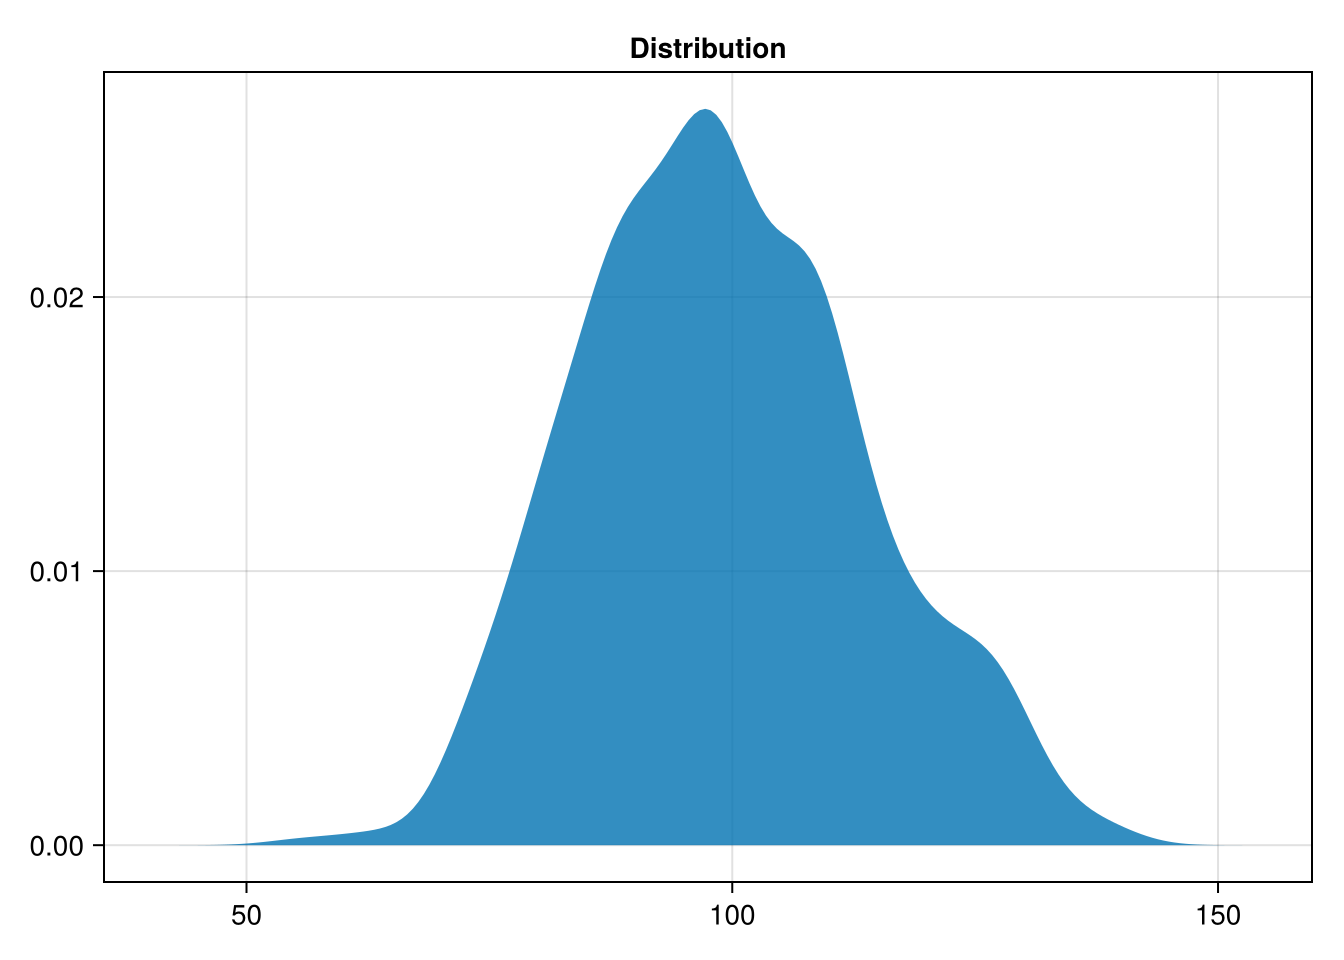

In [3]:
fig = Figure()
ax = Axis(fig[1, 1], title="Distribution")
density!(ax, iq)
fig

In [4]:
#| output: false
#| code-fold: false

@model function model_gaussian(x)
    # Priors
    μ ~ Uniform(0, 200)
    σ ~ Uniform(0, 30)

    # Check against each datapoint
    for i in 1:length(x)
        x[i] ~ Normal(μ, σ)
    end
end

fit_gaussian = model_gaussian(iq)
chain_gaussian = sample(fit_gaussian, NUTS(), 400)

┌ Info: Found initial step size
└   ϵ = 0.025


Sampling:   0%|█                                        |  ETA: 0:00:36

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (400×14×1 Array{Float64, 3}):

Iterations        = 201:1:600
Number of chains  = 1
Samples per chain = 400
Wall duration     = 8.8 seconds
Compute duration  = 8.8 seconds
parameters        = μ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           μ   99.2403    0.6727    0.0333   414.3604   324.9996    0.9993     ⋯
           σ   14.4973    0.4440    0.0187   561.5709   284.5407    0.9976     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%      97.5% 
      Symbol   Float64   Float64   Float64   Float64    Float64 

           μ  

In [5]:
#| code-fold: false

chain_gaussian

Chains MCMC chain (400×14×1 Array{Float64, 3}):

Iterations        = 201:1:600
Number of chains  = 1
Samples per chain = 400
Wall duration     = 8.8 seconds
Compute duration  = 8.8 seconds
parameters        = μ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           μ   99.2403    0.6727    0.0333   414.3604   324.9996    0.9993     ⋯
           σ   14.4973    0.4440    0.0187   561.5709   284.5407    0.9976     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%      97.5% 
      Symbol   Float64   Float64   Float64   Float64    Float64 

           μ  

In [6]:
#| code-fold: false

# Summary (95% CI)
hpd(chain_gaussian)

HPD
  parameters     lower      upper 
      Symbol   Float64    Float64 

           μ   97.8594   100.3178
           σ   13.5687    15.2885
